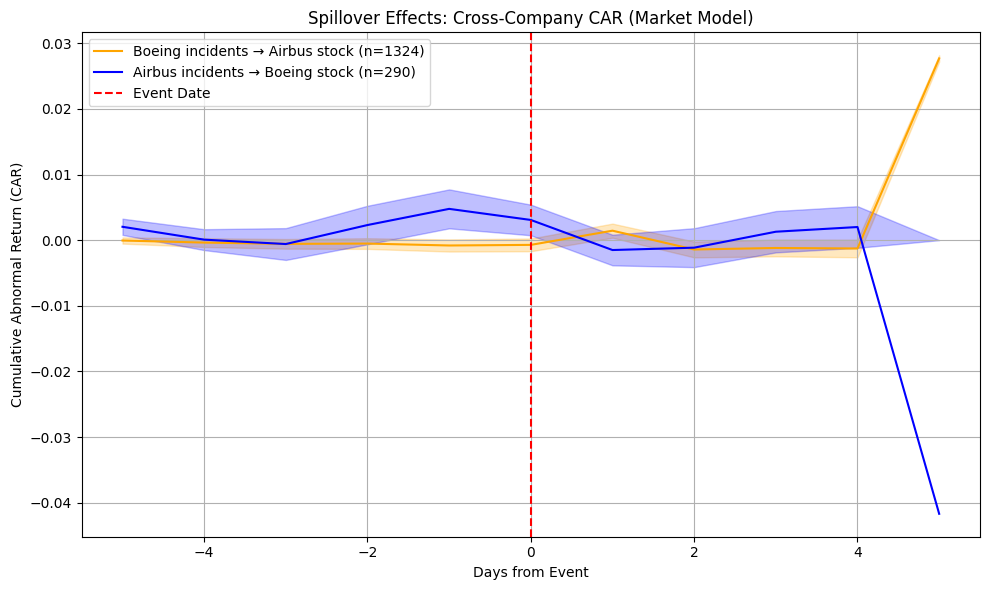


T-test for CAR from Day -10 to +10: Boeing incidents → Airbus stock
  Day -5: t = -0.102, p = 0.9188, mean CAR = -0.00006, n = 919
  Day -4: t = -0.459, p = 0.6466, mean CAR = -0.00037, n = 909
  Day -3: t = -0.632, p = 0.5275, mean CAR = -0.00057, n = 885
  Day -2: t = -0.531, p = 0.5956, mean CAR = -0.00052, n = 909
  Day -1: t = -0.737, p = 0.4613, mean CAR = -0.00081, n = 927
  Day  0: t = -0.617, p = 0.5376, mean CAR = -0.00072, n = 910
  Day  1: t =  1.101, p = 0.2710, mean CAR =  0.00144, n = 897
  Day  2: t = -0.981, p = 0.3267, mean CAR = -0.00142, n = 910
  Day  3: t = -0.776, p = 0.4382, mean CAR = -0.00119, n = 908
  Day  4: t = -0.775, p = 0.4388, mean CAR = -0.00127, n = 887
  Day  5: t =  2.740, p = 0.1114, mean CAR =  0.02769, n = 3

T-test for CAR from Day -10 to +10: Airbus incidents → Boeing stock
  Day -5: t =  1.336, p = 0.1830, mean CAR =  0.00204, n = 190
  Day -4: t =  0.040, p = 0.9683, mean CAR =  0.00007, n = 207
  Day -3: t = -0.210, p = 0.8337, mean CAR = 

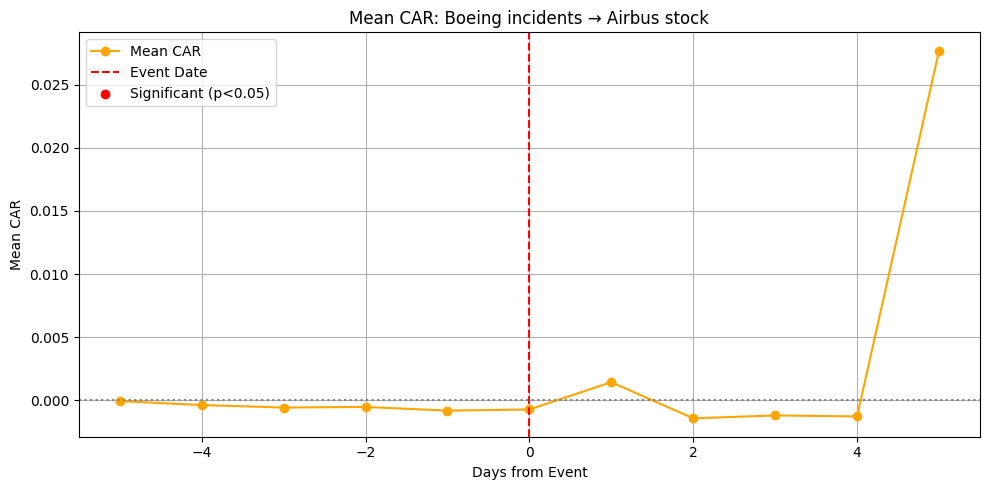

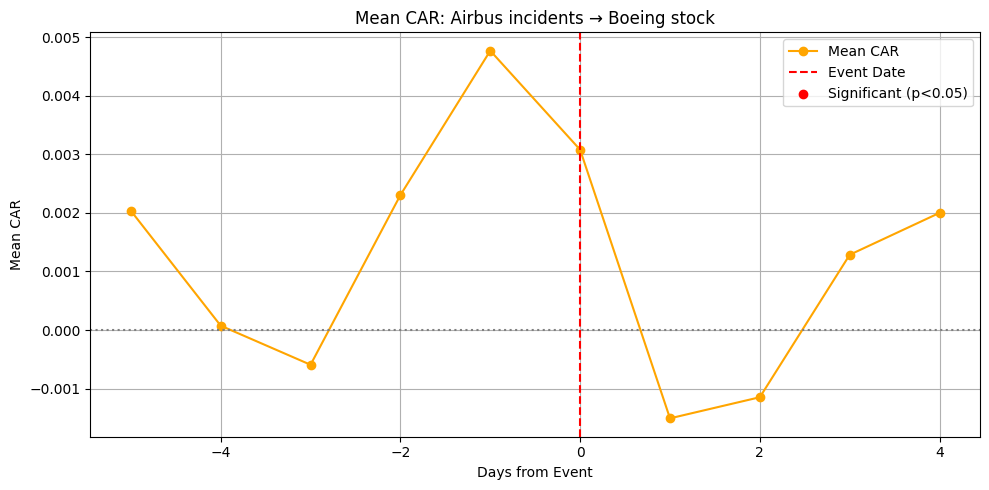

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from statsmodels.api import OLS, add_constant
from scipy.stats import ttest_1samp

# Load stock and event data
boeing = pd.read_csv("BA.csv")
airbus = pd.read_csv("AIR.PA.csv")
boeing_acc = pd.read_excel("boeing_only.xlsx")
airbus_acc = pd.read_excel("airbus_only.xlsx")
sp500 = pd.read_csv("^GSPC.csv")

# Preprocess market and stock returns
sp500['Date'] = pd.to_datetime(sp500['Date'], errors='coerce').dt.tz_localize(None)
sp500.sort_values('Date', inplace=True)
sp500.dropna(subset=['Adj Close'], inplace=True)
sp500['Mkt_Return'] = sp500['Adj Close'].pct_change()

for df in [boeing, airbus]:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.tz_localize(None)
    df.sort_values('Date', inplace=True)
    df.dropna(subset=['Adj Close'], inplace=True)
    df['Return'] = df['Adj Close'].pct_change()

boeing = pd.merge(boeing, sp500[['Date', 'Mkt_Return']], on='Date', how='inner')
airbus = pd.merge(airbus, sp500[['Date', 'Mkt_Return']], on='Date', how='inner')

boeing_acc['EventDate'] = pd.to_datetime(boeing_acc['EventDate'], errors='coerce').dt.tz_localize(None)
airbus_acc['EventDate'] = pd.to_datetime(airbus_acc['EventDate'], errors='coerce').dt.tz_localize(None)
boeing_acc.dropna(subset=['EventDate'], inplace=True)
airbus_acc.dropna(subset=['EventDate'], inplace=True)

# Event study using market model
def market_model_event_study(event_dates, target_df, est_win=60, evt_win=10):
    aligned_data = []
    usable_events = 0
    for event_date in event_dates:
        try:
            start_est = event_date - timedelta(days=est_win + evt_win)
            end_est = event_date - timedelta(days=evt_win + 1)
            est = target_df[(target_df['Date'] >= start_est) & (target_df['Date'] <= end_est)]
            if len(est) < 30:
                continue
            model = OLS(est['Return'], add_constant(est['Mkt_Return'])).fit()
            start_evt = event_date - timedelta(days=evt_win)
            end_evt = event_date + timedelta(days=evt_win)
            evt = target_df[(target_df['Date'] >= start_evt) & (target_df['Date'] <= end_evt)].copy()
            if evt.empty:
                continue
            evt['Expected'] = model.predict(add_constant(evt['Mkt_Return']))
            evt['AR'] = evt['Return'] - evt['Expected']
            evt['CAR'] = evt['AR'].cumsum()
            evt['Day'] = (evt['Date'] - event_date).dt.days
            aligned_data.append(evt[['Day', 'CAR']])
            usable_events += 1
        except:
            continue
    return aligned_data, usable_events

# Run event studies
boeing_dates = boeing_acc['EventDate']
airbus_dates = airbus_acc['EventDate']
airbus_to_boeing_data, _ = market_model_event_study(airbus_dates, boeing)
boeing_to_airbus_data, _ = market_model_event_study(boeing_dates, airbus)

# Plotting function
def plot_cross_car_safe(data_list, label, color):
    if not data_list:
        print(f"No data to plot for {label}")
        return
    combined = pd.concat(data_list)
    avg_car = combined.groupby('Day')['CAR'].mean()
    std_car = combined.groupby('Day')['CAR'].std()
    n = len(data_list)
    x = avg_car.index.to_numpy()
    y = avg_car.values.astype(float)
    y_lower = (avg_car - std_car / np.sqrt(n)).reindex(avg_car.index).fillna(0).values.astype(float)
    y_upper = (avg_car + std_car / np.sqrt(n)).reindex(avg_car.index).fillna(0).values.astype(float)
    plt.plot(x, y, label=f"{label} (n={n})", color=color)
    plt.fill_between(x, y_lower, y_upper, color=color, alpha=0.25)

# Draw combined CAR plot
plt.figure(figsize=(10, 6))
plot_cross_car_safe(boeing_to_airbus_data, 'Boeing incidents → Airbus stock', 'orange')
plot_cross_car_safe(airbus_to_boeing_data, 'Airbus incidents → Boeing stock', 'blue')
plt.axvline(0, color='red', linestyle='--', label='Event Date')
plt.title('Spillover Effects: Cross-Company CAR (Market Model)')
plt.xlabel('Days from Event')
plt.ylabel('Cumulative Abnormal Return (CAR)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("cross_company_car_plot.png")
plt.show()

# T-test + CSV export
def car_daywise_ttest(data_list, label):
    combined = pd.concat(data_list)
    t_results = []
    print(f"\nT-test for CAR from Day -10 to +10: {label}")
    for day in range(-10, 11):
        day_data = combined[combined['Day'] == day]['CAR'].dropna()
        if len(day_data) > 1:
            t_stat, p_value = ttest_1samp(day_data, 0)
            mean_car = day_data.mean()
            t_results.append({'Day': day, 't_stat': t_stat, 'p_value': p_value, 'mean_car': mean_car, 'n': len(day_data)})
            print(f"  Day {day:>2}: t = {t_stat:>6.3f}, p = {p_value:>6.4f}, mean CAR = {mean_car: .5f}, n = {len(day_data)}")
    t_df = pd.DataFrame(t_results)
    plt.figure(figsize=(10, 5))
    plt.plot(t_df['Day'], t_df['mean_car'], marker='o', color='orange', label='Mean CAR')
    plt.axvline(0, color='red', linestyle='--', label='Event Date')
    plt.axhline(0, color='gray', linestyle=':')
    sig = t_df['p_value'] < 0.05
    plt.scatter(t_df['Day'][sig], t_df['mean_car'][sig], color='red', label='Significant (p<0.05)', zorder=5)
    plt.title(f"Mean CAR: {label}")
    plt.xlabel("Days from Event")
    plt.ylabel("Mean CAR")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    filename_prefix = label.replace(' ', '_').replace('→', 'to')
    plt.savefig(f"{filename_prefix}_t_results_plot.png")
    t_df.to_csv(f"{filename_prefix}_t_results.csv", index=False)

car_daywise_ttest(boeing_to_airbus_data, "Boeing incidents → Airbus stock")
car_daywise_ttest(airbus_to_boeing_data, "Airbus incidents → Boeing stock")
